In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.linalg as sla

from collections import defaultdict, Counter
from itertools import combinations
from scipy.spatial import distance

MARKERS = ['o', 'v',  's']
PARAMS = {3: (7, 21, 3),
         2: (5, 10, 2)}
PRECISION = 1e-4

Функция для генерации точек окружности с заданными параметрами

In [2]:
def gen_circle(center, radius, num_dots=10):
    """
    Parameters:
        center: tuple (x, y) of center
        radius: radius value 
        num_dots: number of dots which we need
    """
    a, b = center
    theta = np.linspace(0, 2*np.pi,  num_dots * 100)

    r = radius
    x = r * np.cos(theta) + a
    y = r * np.sin(theta) + b    
    indexes = np.random.choice(num_dots * 100, num_dots, replace=False)
    
    return (x[indexes], y[indexes])

Функция для создания входных данных в виде листа. Основывается на результате gen_circle(center, radius, num_dots)

In [3]:
def gen_input(circles):  
    dataIn = []
    for circle in circles:
        x, y = circle
        dots = list(zip(x,y))
        dataIn.extend(dots)
    np.random.shuffle(dataIn)
    return dataIn

Функция для рисования кружков

In [4]:
def draw_plot(circles):
    """
    Parameters:
        circles: list of tuples (x, y)
    """
    for i, (circle, marker) in enumerate(zip(circles, MARKERS), 1):
        x, y = circle
        plt.plot(x, y, marker, label=f"circle{i}".format(marker))
        
    plt.legend(numpoints=1)
    plt.rc('grid', linestyle="-", color='black')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)

Функции для рисования результата из solution

In [5]:
def draw_result(inputData, result):
    inverse = defaultdict(list)
    for dot in inputData:
        inverse[result[dot]].append(dot)
    result_circles = []
    for value in inverse.values():
        x, y = zip(*value)
        result_circles.append([x, y])
    draw_plot(result_circles)

Функции для генерации тестов

In [6]:
def random(borders, M):
    return np.random.choice(np.arange(*borders), M, replace=False)

def split_number(number, parts):
    if parts == 1:
         return [number]        
    result = []
    last = number    
    for _ in range(parts):
        part = math.ceil(last * np.random.choice(np.arange(1, 100), 1, replace=False) / 100)
        result.append(part)
        last -= part
    return result

def gen_test(N, M, r, borders, draw=True):
    centers = list(zip(random( borders, M), random( borders, M)))
    radiuses = np.random.choice(np.arange(1, r), M, replace=False)
    num_dots = split_number(N, M)
    circles = []
    for num, (center, radius) in zip(num_dots, zip(centers, radiuses)):
        circles.append(gen_circle(center, radius, num))
   
    if draw:
        draw_plot(circles)
    return circles

Функция для проверки результата работы.

In [29]:
def check_result(circles, result):
    map_dict = defaultdict(lambda: -1)
    missmatch = 0
    for circle_cls, circle in enumerate(circles):
        for x, y in zip(circle[0], circle[1]):
            dot = (x, y)
            curr_cls = result[dot]

            if map_dict[circle_cls]  == -1:
                map_dict[circle_cls] = curr_cls

            if map_dict[circle_cls] != curr_cls:
                missmatch += 1

    if missmatch != 0:
         raise Exception(f"!!! Error found missmatches {missmatch} !!!")
    else:
        print("Pass all !!!")
        
        

Класс для хранения параметров окружности и возможности проверить точку на вхождение в окружность.

In [8]:
class Circle:
    
    def __init__(self, dots, a, b, r):
        """
        Parameters:
            dots: set of included dots,
            (a, b): center of circle,
            r: radius 
        """
        self.dots = set(dots)
        self.a = a
        self.b = b
        self.r = r
    
    def check(self, dot):
        """
        Check if external dot lies on circle by calculating euclidean distance from center.
        Parameters:
            dot: external  dot 
        """
        return np.abs(distance.euclidean((self.a, self.b), dot) - self.r) < PRECISION
    
    def __len__(self):
        """
        Returns:
            number of dots
        """
        return len(self.dots)

Функции для сравнения значений с заданной точностью, объектов Circle и нахождения пересечения точек в Circle

In [9]:
def compare(value1, value2):
    return np.abs(value1 - value2) < PRECISION

def compare_circles(circle1, circle2):
    a1, a2 = circle1.a, circle2.a    
    b1, b2 = circle1.b, circle2.b
    r1, r2 = circle1.r, circle2.b    
    return compare(a1, a2) and compare(b1, b2) and compare(r1, r2)

def contains_dots(circle1, circle2):
    return len(circle1.dots & circle2.dots) > 0

Функция создания окружности по 3 точкам, если таковая существует

In [10]:
def check_circle(dots):
    """
    If possible, creates circle on 3 dots, otherwise returns None
    Parameters:
        dots: 3 element list of tuples (x, y)
    Returns:
        Circle object or None    
    """
    x1, y1 = dots[0]
    x2, y2 = dots[1]
    x3, y3 = dots[2]
    
    M = np.array([ [x1**2 + y1**2, x1, y1, 1 ]
                  ,[x2**2 + y2**2, x2, y2, 1 ]
                  ,[x3**2 + y3**2, x3, y3, 1 ]])
    
    M11 = sla.det(np.delete(M, 0, axis=1))
    M12 = sla.det(np.delete(M, 1, axis=1))
    M13 = sla.det(np.delete(M, 2, axis=1))
    M14 = sla.det(np.delete(M, 3, axis=1))
    
    a = 0.5 * M12 / M11
    b = -0.5 * M13 / M11
    square_r = a ** 2 + b ** 2 + M14 / M11
    
    if square_r > 0:
        return Circle(dots, a, b, np.sqrt(square_r))
    
    return None

Функция для поиска первого объекта класса Circle, который удовлетворяет следующим условиям:  
1. sample - точки из которых мы получаем ${sample}\choose{3}$ (сочетания без повторений) троек точек, из которых мы создаем Circle объекты, добавляем в них точки из inputData, если один из Circle имеет $\geq$ threshold точек, то возвращаем
2. sample $\notin$ inputData
3. threshold - min значение количестваа точек Circle, чтоб признать его истинным

In [11]:
def find_fst_circle(inputData, sample, threshold):
    circles = []
    for comb in combinations(sample, 3):
        curr_circle = check_circle(comb)
        if curr_circle is not None:
            unique = True
            
            for circle in circles:
                if compare_circles(curr_circle, circle):
                    circle.dots |= set(comb)
                    unique = False
                    break
            if unique:
                circles.append(curr_circle)
    
    for dot in inputData:
        for circle in circles:
            if circle.check(dot):            
                circle.dots.add(dot)
                if len(circle) >= threshold:
                    return circle
    return None


Функция возвращающая истинный Circle при условии, что входные данные удовлетворили ограничениям (см. в README).

In [12]:
def get_circle(inputData, threshold, needed_size, iterations):
    circle = None
    if len(inputData) >= needed_size:        
        for i in range(0, iterations):
            low = threshold * i
            high = threshold * (i + 1)
            circle = find_fst_circle(inputData, inputData[low : high], threshold)
            if circle is not None:            
                break
    return circle

Функция для поиска объекта класса Circle, который имеет $\geq$ threshold или максимальное возможное на inputData.  
Поиск аналогичен find_fst_circle(inputData, sample, threshold)

In [13]:
def find_max_circle(inputData, M, threshold):
    circles = []    
    for comb in combinations(inputData, 3):
        curr_circle = check_circle(comb)
        if curr_circle is not None:
            unique = True
            
            for circle in circles:
                if compare_circles(curr_circle, circle):
                    circle.dots |= set(comb)
                    unique = False
                    
                    if len(circle) >= threshold:
                        return circle                    
                    break
                    
            if unique:
                circles.append(curr_circle)  
    
    
    max_dots = 3
    max_circle = circles[0]
    all_dots = len(inputData)
    for dot in inputData:     
            
        for circle in circles:
            if circle.check(dot):            
                circle.dots.add(dot)
                if (all_dots - len(circle) == M - 1):
                    return circle
                
                if  max_dots < len(circle) and (all_dots - len(circle) >= M - 1):
                    max_dots = len(circle)
                    max_circle = circle 
                    
                if max_dots >= threshold:
                    return max_circle
                
    return max_circle

Функция классификации точек при условии, что имеется 2 окружности и данные не удовлетворяют ограничениям (подробнее см. в README)

In [14]:
def find2_bad_conditions(inputData):
    result = {}
    if len(inputData) in [2, 3]:
        i = 1
        for dot in inputData:
            result[dot] = i
            i += 1
            i = 1 if i > 2 else i
        return result 
    
    threshold = PARAMS[2][0]
    circle = find_max_circle(inputData, 3, threshold)
    
    for dot in inputData:
        if circle.check(dot):
            result[dot] = 2
        else:
            result[dot] = 1
    return result
    
    

Функция классификации точек при условии, что имеется 3 окружности и данные не удовлетворяют ограничениям (подробнее см. в README)

In [15]:
def find3_bad_conditions(inputData):
    result = defaultdict(lambda:1)
    if len(inputData) in [3, 4]:
        i = 1
        for dot in inputData:
            result[dot] = i
            i += 1
            i = 1 if i > 3 else i
        return result 
    
    threshold = PARAMS[3][0]
    circle = find_max_circle(inputData, 3, threshold)
    
    for dot in inputData:
        if circle.check(dot):
            result[dot] = 3    
    
    return result            

Функция решающая задачу. Алгоритм описан в README

In [117]:
def solution(inputData, M):
    result = defaultdict(lambda : 1)
    
    if M == 1:
        return result    
    
    inputSet = set(inputData)
      
    for m in range(M, 1, -1):
        if len(inputSet) == 0:
            break
            
        threshold, needed_size, iterations = PARAMS[m]
        
        if len(inputSet) < needed_size:
            if m == 3:
                result3 = find3_bad_conditions(inputSet)
                for key in result3.keys():
                    result[key]= result3[key]
                    inputSet.remove(key)                
                continue
            
            if m == 2:                
                result2 = find2_bad_conditions(inputSet)
                for key in result2.keys():
                    result[key]= result2[key]
                return result
        
        classified = set()
        circle = get_circle(list(inputSet), threshold, needed_size, iterations)
        for dot in inputSet:
            if circle.check(dot):
                result[dot] = m
                classified.add(dot)
        inputSet -= classified
    return result

# Тесты

In [91]:
def solve_draw_check(circles, M):
    inputData = gen_input(circles)
    result = solution(inputData, M)
    draw_result(inputData, result)
    check_result(circles, result)

### Tecт на ~100 точек, 3 окружности, поле (-1000000, 1000000)

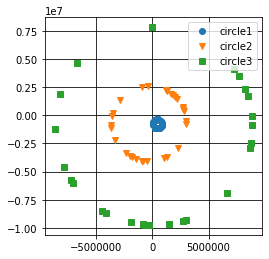

In [93]:
N = 100
M = 3
circles = gen_test(N, M, 10000000, (-1000000, 1000000))

Pass all !!!
Wall time: 30.1 ms


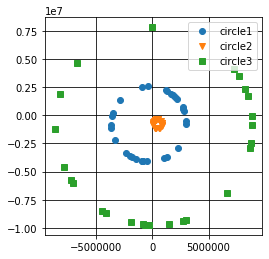

In [99]:
%%time
solve_draw_check(circles, 3)

### Tecт на ~10000 точек, 3 окружности, поле (-1000000, 1000000)

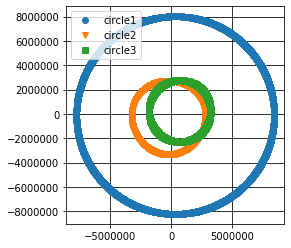

In [100]:
N = 10000
M = 3
circles = gen_test(N, M, 10000000, (-1000000, 1000000))

Pass all !!!
Wall time: 196 ms


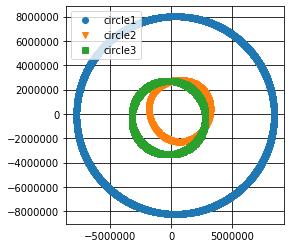

In [101]:
%%time
solve_draw_check(circles, 3)

## Кастомные тесты 3 окружности.

### Тест 1

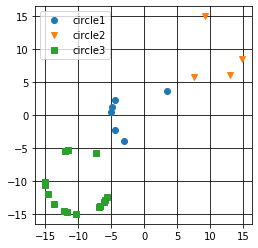

In [102]:
circles = []
circles.append(gen_circle((0, 0), 5, 6))
circles.append(gen_circle((10, 10), 5, 4))
circles.append(gen_circle((-10, -10), 5, 16))
draw_plot(circles)

Pass all !!!
Wall time: 25.1 ms


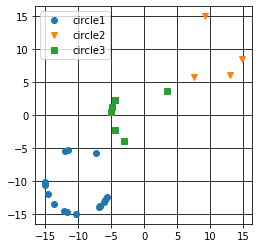

In [103]:
%%time
solve_draw_check(circles, 3)

### Тест 2

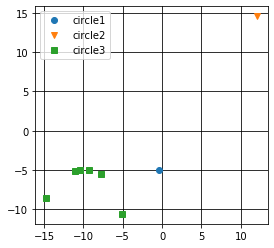

In [104]:
circles = []
circles.append(gen_circle((0, 0), 5, 1))
circles.append(gen_circle((10, 10), 5, 1))
circles.append(gen_circle((-10, -10), 5, 6))
draw_plot(circles)

Pass all !!!
Wall time: 25.1 ms


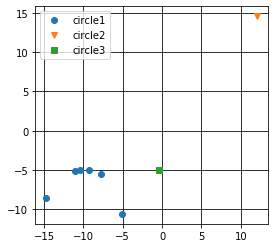

In [105]:
%%time
solve_draw_check(circles, 3)

# Кастомные тесты 2 окружности.

### Тест 1

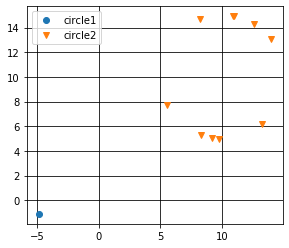

In [106]:
circles = []
circles.append(gen_circle((0, 0), 5, 1))
circles.append(gen_circle((10, 10), 5, 10))
draw_plot(circles)

Pass all !!!
Wall time: 15 ms


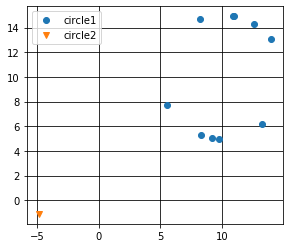

In [108]:
%%time
solve_draw_check(circles, 2)

### Тест 2

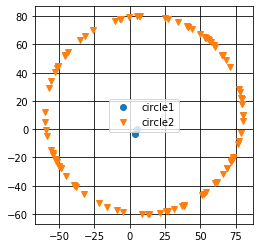

In [111]:
circles = []
circles.append(gen_circle((0, 0), 5, 3))
circles.append(gen_circle((10, 10), 70, 100))
draw_plot(circles)

Pass all !!!
Wall time: 15.1 ms


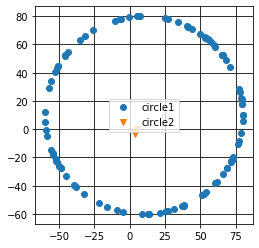

In [112]:
%%time
solve_draw_check(circles, 2)

# Тест 3 точки

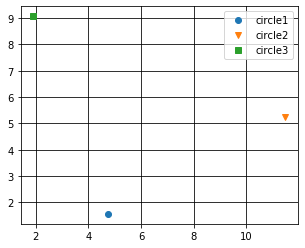

In [120]:
circles = []
circles.append(gen_circle((0, 0), 5, 1))
circles.append(gen_circle((10, 10), 5, 1))
circles.append(gen_circle((-1, 5), 5, 1))
draw_plot(circles)

Pass all !!!


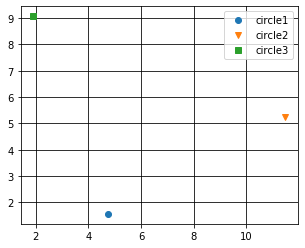

In [121]:
solve_draw_check(circles, 3)